# Assignment A1: English Wikipedia page views 2008 - 2019
## Richard Todd

Data was gathered from the Wikimedia [Pageview](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) and [Pagecount](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) REST APIs, Wikimedia Foundation, 2019. CC-BY-SA 30. 

## Step 1: Data acquisition
The code in this section is based on example material provided to students in the course [wiki](https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments#A1:_Data_curation) made freely available for use in this assignment.

First we import python libraries used to access, process and plot the data:

In [226]:
import json
import requests
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.patches as mpatches

The below establishes the two API end-points, each covering different time periods. Data used in the embedded visualization was accessed on 9/28/2019.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

We then establish five sets of paramters for the queries, covering the two APIs and different access type (mobile and desktop). The more recent Pageview API also allows the filtering of non-human traffic, so this parameter is included.

In [38]:
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 # assignment calls for data from January 2008
                 "start" : "2008010100",
                 # legacy API covers data only until July 2016
                 "end" : "2016080100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 # assignment calls for data from January 2008
                 "start" : "2008010100",
                 # legacy API covers data only until July 2016
                 "end" : "2016080100"
                    }

params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    # data available from July 2015
                    "start" : "2015070100",
                    # as assignment calls for data through August 2019, using 1st day of Sep 2019 as end point
                    "end" : '2019091000'
                        }

params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    # data available from July 2015
                    "start" : "2015070100",
                    # as assignment calls for data through August 2019, using 1st day of Sep 2019 as end point
                    "end" : '2019091000'
                        }

params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    # data available from July 2015
                    "start" : "2015070100",
                    # as assignment calls for data through August 2019, using 1st day of Sep 2019 as end point
                    "end" : '2019091000'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/rcctodd',
    'From': 'rcctodd@uw.edu'
}

We then create simple functions to call the APIs with the defined input paramters and to save the output JSON files, then run them both for each of the five queries.

In [5]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [40]:
legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)
pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)
pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)

In [48]:
def save_json(data, filename):
    with open(filename, "w") as json_output:
        json.dump(data, json_output)

In [236]:
save_json(legacy_desktop,"pagecounts_desktop-site_200801-201607.json")
save_json(legacy_mobile,"pagecounts_mobile_200801-201607.json")
save_json(pageviews_desktop,"pageviews_desktop_201507-201909.json")
save_json(pageviews_mobileweb,"pageviews_mobile-web_201507-201909.json")
save_json(pageviews_mobileapp,"pageviews_mobile-app_201507-201909.json")

## Step 2: Data processing

As our target is a combined CSV file, we reshape the the API output data to dataframes for easier manipulation.

In [136]:
lst=[]
for item in pageviews_desktop["items"]:
    lst.append([item['access'],item["timestamp"],item["views"],"pageviews"])
pageviews_desktop_df=pd.DataFrame(lst,columns=['access','timestamp',"views","api"])

lst=[]
for item in pageviews_mobileweb["items"]:
    lst.append([item['access'],item["timestamp"],item["views"],"pageviews"])
pageviews_mobileweb_df=pd.DataFrame(lst,columns=['access','timestamp',"views","api"])

lst=[]
for item in pageviews_mobileapp["items"]:
    lst.append([item['access'],item["timestamp"],item["views"],"pageviews"])
pageviews_mobileapp_df=pd.DataFrame(lst,columns=['access','timestamp',"views","api"])

lst=[]
for item in legacy_desktop["items"]:
    lst.append([item['access-site'],item["timestamp"],item["count"],"pagecounts"])
legacy_desktop_df=pd.DataFrame(lst,columns=['access','timestamp',"views","api"])

lst=[]
for item in legacy_mobile["items"]:
    lst.append([item['access-site'],item["timestamp"],item["count"],"pagecounts"])
legacy_mobile_df=pd.DataFrame(lst,columns=['access','timestamp',"views","api"])

To aid comparability between the two API datasets, we combine the two types of Pageview mobile traffic, then combine all the API dataframes into a single dataframe to make bulk processing easier:

In [152]:
pageviews_mobile_comb_df =pageviews_mobileweb_df.append(pageviews_mobileapp_df) 
pageviews_mobile_comb_df = pageviews_mobile_comb_df.groupby('timestamp', as_index=False).sum()
pageviews_mobile_comb_df['access'] = "all_mobile"
pageviews_mobile_comb_df['api'] = "pageviews"

In [178]:
combined_df = pageviews_mobile_comb_df.append(pageviews_desktop_df, sort=True)
combined_df = combined_df.append(legacy_desktop_df, sort=True)
combined_df = combined_df.append(legacy_mobile_df, sort=True)

The following code separates the API timestamp data into four-digit year (YYYY) and two-digit month (MM); discarding values for day and hour (DDHH):

In [179]:
combined_df['year'] = combined_df['timestamp'].str[:4]
combined_df['month'] = combined_df['timestamp'].str[4:6]
del(combined_df['timestamp'])

Finally, we combine the API and access columns into a single identifying key, pivot the data to the required wide data format, rename columns, add totals by API, replace missing data  with 0s and save the resulting frame as a CSV.


In [180]:
combined_df['api_access'] = combined_df['api']+combined_df['access']
del(combined_df['access'])
del(combined_df['api'])

In [181]:
output_df = pd.pivot_table(combined_df,columns="api_access", index = ['year','month'],values='views').reset_index().rename_axis(None, 1)
output_df.columns = ['year', 'month', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_mobile_views',
                     'pageview_desktop_views']
output_df['pagecount_all_views'] = output_df['pagecount_desktop_views'] + output_df['pagecount_mobile_views']
output_df['pageview_all_views'] = output_df['pageview_desktop_views'] + output_df['pageview_mobile_views']
output_df= output_df.fillna(0)

#note that the name is misleading, but as requested...
output_df.to_csv('en-wikipedia_traffic_200712-201809.csv')

## Step 3: Data analysis

We load the CSV file form the previous step and make trasnformations that will make graphing easier: replacing 0s with NaNs, combining month and year into a single date field and sorting the dataframe.

In [ ]:
graph_df = pd.read_csv('en-wikipedia_traffic_200712-201809.csv')

In [186]:
graph_df = graph_df.replace(to_replace=0, value=pd.np.nan)
graph_df['full_date'] = graph_df.apply(lambda x: pd.datetime(int(x.year), int(x.month), 1), axis=1)
graph_df = graph_df.sort_values('full_date')

When graphing, we align colors between APIs, using dashes to indicate the different datasources:

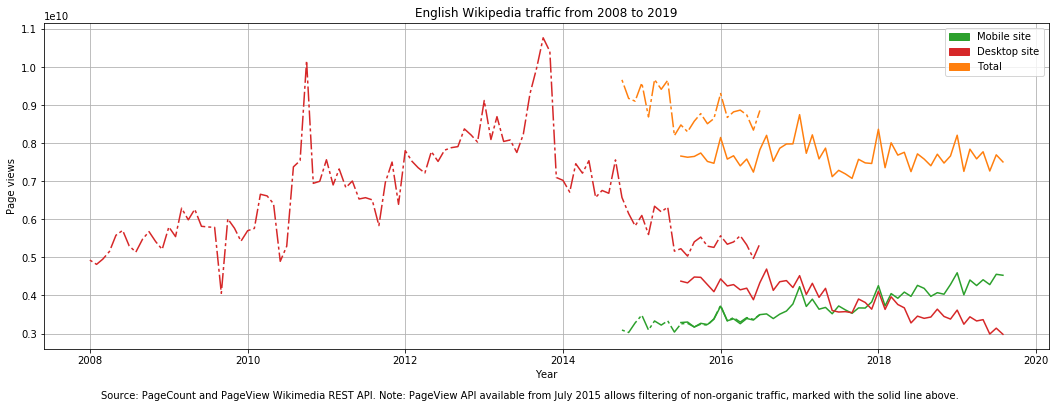

In [235]:
fig, ax = plt.subplots(figsize=(18, 6))

line1 = ax.plot(graph_df.full_date, graph_df.pageview_all_views,'C1')
line2 = ax.plot(graph_df.full_date, graph_df.pageview_mobile_views,'C2')
line3 = ax.plot(graph_df.full_date, graph_df.pageview_desktop_views,'C3')

line4, = ax.plot(graph_df.full_date, graph_df.pagecount_all_views,'C1')
line4.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break
line5, = ax.plot(graph_df.full_date, graph_df.pagecount_mobile_views,'C2')
line5.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break
line6, = ax.plot(graph_df.full_date, graph_df.pagecount_desktop_views,'C3')
line6.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

c2_patch = mpatches.Patch(color='C2', label='Mobile site')
c3_patch = mpatches.Patch(color='C3', label='Desktop site')
c1_patch = mpatches.Patch(color='C1', label='Total')

plt.legend(handles=[c2_patch,c3_patch,c1_patch])

plt.figtext(0.5, 0.01, 'Source: PageCount and PageView Wikimedia REST API. Note: PageView API available from July 2015 allows filtering of non-organic traffic, marked with the solid line above.', horizontalalignment='center')
plt.xlabel("Year")
plt.ylabel("Page views")
plt.title("English Wikipedia traffic from 2008 to 2019")
plt.grid()
plt.savefig('wiki_en_traffic_0819.png')

The final graph includes annotation of the important change in datasource. Note that scientific notation is used on the x axis.